# NCM, HVC Lesion Analysis

This notebook is used to compute the statistics and generate figures presented in the [paper]. 

## 1 Reading the data

Reading the data is facilitated by the class `zf_data.Tsvk`, which provides some helper methods to compute quantities used in the paper/figures. The name "Tsvk" refers to the term $T^{sv}_k$ from the methods used to compute $p(\mathrm{int}|s,v,k)$ --- that is the probability that subject $s$ interrupts a particular vocalizer $v$, given that it has seen $k$ informative trials of that vocalizer. 

Note that this data structure is not required for any analyses, since the raw data can be loaded directly from `zebra-finch-memory-lesions/data/behavior/TrialData.csv` and processed however you choose. However, it can be far more convenient to use this structure since it predefines methods used to perform the analyses found in the paper.

We also provide a helper functino `zf_data.load_trials()` for loading the TrialData.csv, which returns a pandas DataFrame containing all operant trials for all subjects.

```python
from zf_data import load_trials
df = load_trials()
```

## 2 Using the Tsvk data structure

A `Tsvk` instance is initialized with (1) a pandas DataFrame containing a filtered subset of operant trials, and (2) a value of `k_max`, the largest informative trial bin to include in the analysis.

```python
from zf_data import Tsvk
tsvk = Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
```

### Methods

Here are some of the helper methods `Tsvk` defines

* `tsvk.p(subject, vocalizer, k)`
    > Averages $p(\mathrm{int}|s,v,k)$ over vocalizers. Use `Tsvk.re.p(...)` and `Tsvk.nore.p(...)` to restrict it to either Re or NoRe vocalizers respectively.

* `tsvk.re.p_by_k()`, `Tsvk.nore.p_by_k()`
    > for each $k$, estimates $p(\mathrm{int}|Re,k)$ and $p(\mathrm{int}|NoRe,k)$ by jackknifing over subjects. These are used to produce the group average learning curves in Figure 3A and 3B.

* `tsvk.re.odds_by_subjects(k)`, `Tsvk.nore.odds_by_subjects(k)`
    > for each $k$, computes odds of interrupting Re or NoRe vocalizers of each subject

* `tsvk.logOR_by_subjects(k)`
    > for each $k$, compute
    $$
    \mathrm{logOR}(s, k)=\mathrm{log}(Odds(\mathrm{int}|s,NoRe,k)) - \mathrm{log}(Odds(\mathrm{int}|s,Re,k))
    $$
    for each subject, returning it in a pandas DataFrame

* `tsvk.logOR()`
    > Computes $\mathrm{logOR}(k)$ for $k \in \{0, .., k_{max}\}$. At each $k$, the estimate and SEM is estimated using a jackknife procedure over subjects, returning it in a pandas DataFrame. The condition $\mathrm{logOR}(k) > 0$ is tested with a one-sided paired t-test over subjects. The Benjamini-Hochberg false discovery correction used in the paper should be applied after calling this method.

* `tsvk.fisher_exact()`
    > Computes the result of a Fisher exact test on the entire DataFrame, with the following contingency matrix. The Fisher exact test returns the estimate of $\mathrm{OR}=\frac{ad}{bc}$, 95% confidence bounds on the estimate, and a p-value. 

|         |Interruptions|Waits|
|---------|:-:|:-:|
|NoRe     | a | c |
|Re       | b | d |

### Note on caching results

Computing the quantities used in the paper can be relatively slow (10s of seconds). Each `Tsvk` instance caches the result of most of its methods when they are called once, so that re-running a cell happens relatively instantaneously.

Sometimes multiple figures/analyses operate on the same subset of data (e.g. the top and bottom figures of Figure 3A and 3B). To avoid re-instantiating a `Tsvk` instance for each analysis (which would cause all the computations to be re-run), a function called `get_or_create_Tsvk` is defined in this notebook which restores a previous `Tsvk` instance if the dataframe and k_max parameter are identical.

## 3 Typical analysis pattern


The pattern used in this notebook is usually:

1. Instantiate a Tsvk object for one or more ranges of data (e.g. S1 & prelesion), e.g.

```python
tsvk = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
```

2. Compute some quantity or quantities of interest, e.g.

```python
re_probabilities = tsvk.re.p_by_k()
nore_probailities = tsvk.nore.p_by_k()
```

3. Plot or perform statistics on the returned quantities, e.g.

```python
import matplotlib.pyplot as plt
plt.errorbar(re_probabilities.k, re_probabilities.logOR, y_err=2 * re_probabilities.SE)
plt.errorbar(nore_probabilities.k, nore_probabilities.logOR, y_err=2 * nore_probabilities.SE)
```

In [1]:
import os
import sys

# TODO: create a setup.py instead of setting the path manually
sys.path.append("/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/")

In [118]:
import datetime
import time
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway
import scipy.stats
from scipy.stats import f_oneway

from zf_data import Tsvk, load_trials
from zf_data.stats import false_discovery, likelihood_ratio_test
from zf_data.plotting import (
    border,
    color_by_reward,
    draw_k_axis,
    draw_logor_axes_markers,
    draw_probability_axes_markers,
    figure_cm,
    fig_grid,
    smoothhist,
    shaded_line,
)

In [3]:
%load_ext autoreload
%autoreload 2

## Constants

`K_MAX_INITIAL`: This determines how many informative trials we count when analyzing the initial response of a subject to a vocalizer. Since NoRe can be distinguished from Re after 2 or 3 informative trials, count only trials that occured up to and including `K_MAX_INITIAL=2`.

In [105]:
SAVE_FIGS = True  #@param {type: "boolean"}
FIGDIR = "figures/svg_originals"  #@param {type: "string"}
FIGDIR = Path(FIGDIR)

HVC_COLOR = "#e6438c"  #@param {type: "string"}
CTRL_COLOR = "#777777"  #@param {type: "string"}
NCM_COLOR = "#19b382"  #@param {type: "string"}
NEUTRAL_COLOR = "#1968c2"  #@param {type: "string"}
HVC_LINESTYLE = "--"  #@param {type: "string"}
CTRL_LINESTYLE = (0, (3, 1, 1, 1)) #@param {type: "raw"}
NCM_LINESTYLE = "-"  #@param {type: "string"}
AX_COLOR = "#666666"  #@param {type: "string"}
AXIS_SIZE = 14  #@param {type: "integer"}
LABEL_SIZE = 16  #@param {type: "integer"}

K_MAX_INITIAL = 3 #@param {type: "integer"}

FIGDIR.mkdir(parents=True, exist_ok=True)

# JNeurosci column sizes in cm
COL1 = 8.5  #@param {type: "number"}
COL1_5 = 11.6  #@param {type: "number"}
COL2 = 17.6  #@param {type: "number"}

COLORMAP = {
    "NCM": NCM_COLOR,
    "HVC": HVC_COLOR,
    "CTRL": CTRL_COLOR
}
LINEMAP = {
    "NCM": NCM_LINESTYLE,
    "HVC": HVC_LINESTYLE,
    "CTRL": CTRL_LINESTYLE,
}

In [106]:
mpl.rcParams["grid.color"] = AX_COLOR
mpl.rcParams["axes.edgecolor"] = AX_COLOR
mpl.rcParams["xtick.labelcolor"] = AX_COLOR
mpl.rcParams["ytick.labelcolor"] = AX_COLOR
mpl.rcParams["xtick.color"] = AX_COLOR
mpl.rcParams["ytick.color"] = AX_COLOR
mpl.rcParams["ytick.color"] = AX_COLOR

mpl.rcParams["axes.titlecolor"] = AX_COLOR
mpl.rcParams["axes.labelcolor"] = AX_COLOR
mpl.rcParams["figure.edgecolor"] = AX_COLOR
mpl.rcParams["grid.color"] = AX_COLOR
mpl.rcParams["legend.labelcolor"] = AX_COLOR
mpl.rcParams["legend.edgecolor"] = AX_COLOR
mpl.rcParams["text.color"] = AX_COLOR

def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

### Helper functions

In [64]:
def get_or_create_Tsvk(df: pd.DataFrame, k_max: int = None) -> Tsvk:
    """Create a Tsvk instance from a dataframe, or return a cached one for that data
    
    If the df.index and k_max match a previously computed Tsvk, return that one. Otherwise,
    instantiate a new Tsvk() instance.
    
    Tsvk instances are hashed by a tuple of the dataframe index and k_max requested.
    """
    key = (tuple(df.index), k_max)
    if key not in get_or_create_Tsvk.cache:
        get_or_create_Tsvk.cache[key] = Tsvk(df, k_max=k_max)
    return get_or_create_Tsvk.cache[key]
get_or_create_Tsvk.cache = {}


def test_get_or_create_Tsvk(df: pd.DataFrame):
    backup = get_or_create_Tsvk.cache.copy()
    get_or_create_Tsvk.cache = {}
    t1 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t2 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t3 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=12)
    t4 = get_or_create_Tsvk(df[(df.LesionStage == "postlesion") & (df.VocalizerSet == "S2")], k_max=12)
    
    assert t1 is t2
    assert t1 is not t3
    assert t2 is not t3
    assert t1 is not t4
    assert t2 is not t4
    print("Tests pass")
    
    get_or_create_Tsvk.cache = backup
    


## Data modifications

Some issues with the data that should be addressed during data analysis and figure plotting are made here

In [67]:
POTENTIAL_L = ["RedHpi0710F", "WhiBlu5805F"]
PARTIAL_HVC = ["RedGra7912M"]
SET_2_CUT_SHORT = "BluWhi3230M" # Health issues
MICROPHONE_NOT_WORKING_DATE = datetime.date(2020, 11, 20)

## Load data

In [10]:
df = load_trials()

In [11]:
test_get_or_create_Tsvk(df)

Tests pass


## Figure 1

Figure 1 shows general task information and lesion images, and is not generated by this notebook.

## Figure 2

TBD

## Figure 3 and 4

Figures 3 and 4 plot learning curves before and after lesion (as probabilities and as odds ratios).

These figures are generated together here since they were originally one large figure - they have been split into two figures in the latest iteration of the paper.

In [107]:
def figure3a(ax: plt.Axes = None):
    """Plots learning curves for inital learning of S1 stimuli before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (initial learning)
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
    ], k_max=11)

    # Get probability of interruption (avg over subjects) for each k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

def figure3a_odds(ax: plt.Axes = None):
    """Plots learning curves for inital learning of S1 stimuli before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (initial learning)
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    logOR = tsvk.logOR()

    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    first_bin = np.where(pvalues < 0.05)[0][0]
    
    print("Figure 3A (Bottom)")
    print("------------------")
    print(f"  Significance by bin: {false_discovery(pvalues, alpha=0.05)}")
    print(f"  First bin where significant: k={first_bin}")
    
    # Draw overlay lines showing the logOR of each individual group
    
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)
        
        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[treatment],
                "color": COLORMAP[treatment],
                "zorder": -1,
                "linewidth": 1,
            },
        )

def figure3b(ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get probability of interruption as a function of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

    
def figure3b_odds(ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()
        
    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    logOR = tsvk.logOR()

    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    first_bin = np.where(logOR["pvalue"] < 0.05)[0][0]
    
    print("Figure 3B (Bottom)")
    print("------------------")
    print(f"  Significance by bin: {false_discovery(logOR['pvalue'], alpha=0.05)}")
    print(f"  First bin where significant: k={first_bin}, p={logOR['pvalue'][0]:.5f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.5f}")

    # Draw overlay lines showing the logOR of each individual group

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[treatment],
                "color": COLORMAP[treatment],
                "zorder": -1,
                "linewidth": 1,
            },
        )
    

In [108]:
def figure4a(treatment: str, ax: plt.Axes = None):
    """Plots learning curves for initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    # Get post-lesion data in initial sessions after lesion
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
    ], k_max=11)

    # Compute probability of interruption as a funciton of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

    
def figure4b(ax: plt.Axes = None):
    """Plots odds ratios of lesioned birds during initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    print("Figure 4B")
    print("---------")

    # Overlay odds ratio curves for each treatment type

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[treatment],
                "linestyle": LINEMAP[treatment],
            },
        )
        
        pvalues = logOR["pvalue"]
        first_bin = np.where(pvalues < 0.05)[0][0]
        
        print(f" {treatment}")
        print("--------")
        print(f"  Significance by bin: {false_discovery(pvalues, alpha=0.05)}")
        print(f"  First bin where significant: k={first_bin}")        
        print(f"  t-test in bin k=0; {treatment}: t({logOR['dof'][0]})={logOR['tstat'][0]:.5f}, p={pvalues[0]:.5f}")
        print(f"  t-test in bin k=1; {treatment}: t({logOR['dof'][1]})={logOR['tstat'][1]:.5f}, p={pvalues[1]:.5f}")


def figure4c_data(ax: plt.Axes = None):
    """Generates dictionary of "delta", the change in logOR before to after lesion for S1, for each treatment
    
    We split also generate a table including pre/post lesion and call type in case we want to model call type's
    effect. For the figure, we show the group data.
    
    We also return "post", which is just the post-lesion logOR
    """
    delta = {}
    post = {}
    # call_type_delta_rows = []
    
    k_array = tuple(np.arange(K_MAX_INITIAL + 1))  # The values of k to compute over

#     # First, we generate the dataset with pre/post lesion and call type broken out into their own rows
#     for treatment in ["NCM", "HVC", "CTRL"]:
#         tsvk_song_pre = get_or_create_Tsvk(df[
#             (df.LesionStage == "prelesion")
#             & (df.VocalizerSet == "S1")
#             & (df.SubjectTreatment == treatment)
#             & (df.StimulusCallType == "SO")
#             & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
#         ], k_max=11)
#         tsvk_song_post = get_or_create_Tsvk(df[
#             (df.LesionStage == "postlesion")
#             & (df.VocalizerSet == "S1")
#             & (df.SubjectTreatment == treatment)
#             & (df.StimulusCallType == "SO")
#         ], k_max=11)

#         tsvk_dc_pre = get_or_create_Tsvk(df[
#             (df.LesionStage == "prelesion")
#             & (df.VocalizerSet == "S1")
#             & (df.SubjectTreatment == treatment)
#             & (df.StimulusCallType == "DC")
#             & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
#         ], k_max=11)
#         tsvk_dc_post = get_or_create_Tsvk(df[
#             (df.LesionStage == "postlesion")
#             & (df.VocalizerSet == "S1")
#             & (df.SubjectTreatment == treatment)
#             & (df.StimulusCallType == "DC")
#         ], k_max=11)
        
        
#         def make_row(row, call_type):
#             return {
#                 "CallType": call_type,
#                 "Treatment": treatment,
#                 "Delta": row["logOR"], 
#                 "Subject": row["Subject"]
#             }
        
#         tsvk_song = tsvk_song_pre.logOR_by_subjects(k=k_array).set_index("Subject").join(
#             tsvk_song_post.logOR_by_subjects(k=k_array),
#             on="Subject",
#             rsuffix="-post"
#         )
#         tsvk_song["Delta"] = tsvk_song.apply(lambda row: row["logOR-post"] - row["logOR"], axis=1)

#         tsvk_dc = tsvk_dc_pre.logOR_by_subjects(k=k_array).set_index("Subject").join(
#             tsvk_dc_post.logOR_by_subjects(k=k_array),
#             on="Subject",
#             rsuffix="-post"
#         )
#         tsvk_dc["Delta"] = tsvk_dc.apply(lambda row: row["logOR-post"] - row["logOR"], axis=1)

#         call_type_delta_rows.extend(np.concatenate([
#             tsvk_song["Delta"].apply(lambda row: make_row(row, "Song"), axis=1),
#             tsvk_dc["Delta"].apply(lambda row: make_row(row, "Song"), axis=1),
#         ]))

    # Second, we generate data combining both call types (as in the other learning curve figures)
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
        ], k_max=11)
        tsvk_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)

        delta[treatment] = np.array(
            tsvk_post.logOR_by_subjects(k=k_array)["logOR"]
            - tsvk_pre.logOR_by_subjects(k=k_array)["logOR"]
        )
        
        post[treatment] = np.array(
            tsvk_post.logOR_by_subjects(k=k_array)["logOR"]
        )

    return delta, post #, pd.DataFrame(call_type_delta_rows)



Figure Dimensions 17.60cm x 6.00cm
Figure 3A (Bottom)
------------------
  Significance by bin: [False False False False  True  True  True  True  True  True  True  True]
  First bin where significant: k=4
Figure 3B (Bottom)
------------------
  Significance by bin: [ True  True  True  True  True  True  True  True  True  True  True  True]
  First bin where significant: k=0, p=0.00087, t(20) = 3.61228
Figure 4B
---------
 NCM
--------
  Significance by bin: [False  True False  True  True  True  True  True  True  True  True  True]
  First bin where significant: k=1
  t-test in bin k=0; NCM: t(9)=-0.67597, p=0.74197
  t-test in bin k=1; NCM: t(9)=2.70698, p=0.01206
 HVC
--------
  Significance by bin: [ True  True  True  True  True  True  True  True  True  True  True  True]
  First bin where significant: k=0
  t-test in bin k=0; HVC: t(6)=4.04978, p=0.00336
  t-test in bin k=1; HVC: t(6)=7.41072, p=0.00016
 CTRL
--------
  Significance by bin: [False  True  True  True  True  True  True  Tr

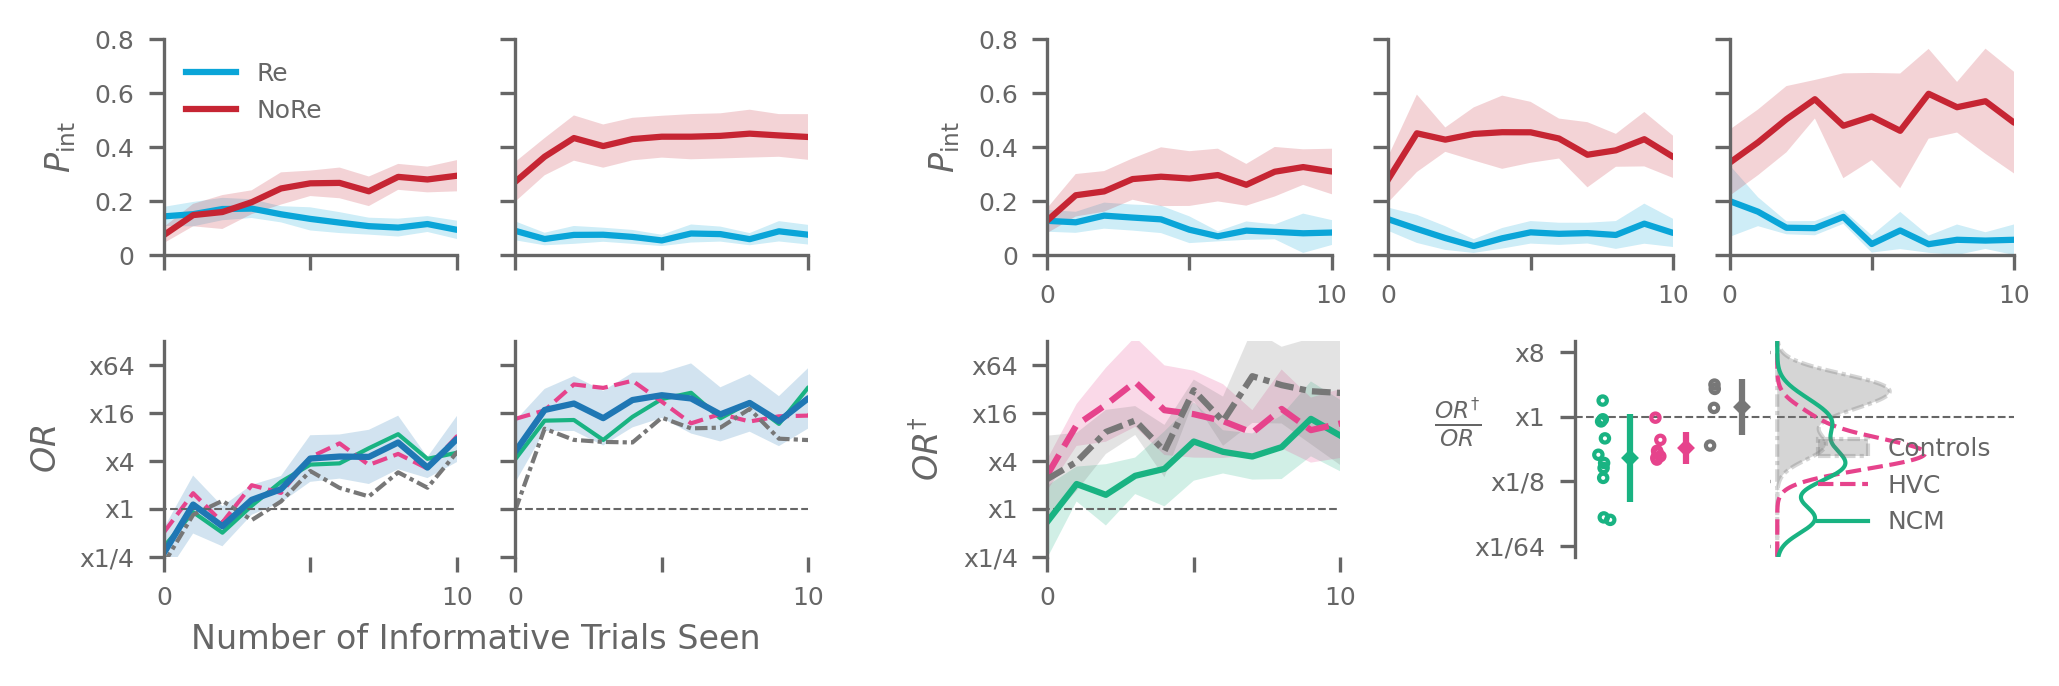

In [109]:
from matplotlib.gridspec import GridSpec

fig = figure_cm(COL2, 6, dpi=300)
hspace = 0.4
wspace = 0.2
gridspec_kw = {"hspace": hspace, "wspace": wspace}

subfigs = fig.subfigures(1, 2, width_ratios=[2, 3])

##########
# 3A, 3B #
##########
axes = subfigs[0].subplots(2, 2, sharex=True, gridspec_kw=gridspec_kw)

figure3a(axes[0, 0])
figure3b(axes[0, 1])
figure3a_odds(axes[1, 0])
figure3b_odds(axes[1, 1])

for ax in axes[0]:
    draw_probability_axes_markers(ax=ax)
for ax in axes[1]:
    draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
    ax.set_ylim(-2, 7)
    border(ax, 1, 0, 0, 0)
for ax in axes[0]:
    ax.tick_params(labelbottom=False)
for ax in axes[:, 1]:
    ax.tick_params(labelleft=False)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)
    
axes[0, 0].legend(fontsize=6, loc="upper left", frameon=False)

axes[0, 0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)
axes[1, 0].set_ylabel(r"$OR$", fontsize=8)

subfigs[0].supxlabel("Number of Informative Trials Seen", fontsize=8)
subfigs[0].subplots_adjust(bottom=0.15)

# 3C: Lesioned subject performances
subfigs_right = subfigs[1].subfigures(1, 1)

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes, delete_axes = subfigs_right.subplots(2, 3, sharey=True, gridspec_kw=gridspec_kw)
for ax in delete_axes:
    ax.remove()

######
# 4A #
######
figure4a("NCM", ax=axes[0])
figure4a("HVC", ax=axes[1])
figure4a("CTRL", ax=axes[2])

for ax in axes:
    draw_probability_axes_markers(ax=ax)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)

axes[0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)


# 4B: Lesioned subject odds ratios
subfigs_bottom = subfigs[1].subfigures(1, 1)
delete_axes, axes = subfigs_bottom.subplots(2, 2, gridspec_kw=dict(width_ratios=[1, 2], **gridspec_kw))
for ax in delete_axes:
    ax.remove()

# Split the remaining space 
last_ax_position = axes[1].get_position()
bounds = last_ax_position.bounds
w = bounds[2]
scatter_ax_bounds = [
    bounds[0] + 1.5 * w/6, 
    bounds[1], 
    2 * w / 6, 
    bounds[3]
]
last_ax_position.x0 = (last_ax_position.x0 + 3.5 * w / 6)
axes[1].set_position(last_ax_position)
ax_scatter = subfigs_bottom.add_axes(scatter_ax_bounds)

# axes[1].sharey(ax_scatter)

######
# 4B #
######
figure4b(ax=axes[0])

draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=axes[0])
axes[0].set_ylim(-2, 7)
draw_k_axis(k_max=11, ax=axes[0])
axes[0].set_ylabel(r"$OR^{\dagger}$", fontsize=8)
border(axes[0], 1, 0, 0, 0)


######
# 4C #
######
delta, post = figure4c_data()

ax = axes[1]
smoothhist(delta["CTRL"], range=(-6.5, 3.5), bins=15, ax=ax, color=CTRL_COLOR, label="Controls", orientation="horizontal", fill=True, alpha=0.3, linewidth=1, linestyle=CTRL_LINESTYLE)
smoothhist(delta["HVC"], range=(-6.5, 3.5), bins=15, ax=ax, color=HVC_COLOR, label="HVC", orientation="horizontal", linewidth=1, linestyle=HVC_LINESTYLE)
smoothhist(delta["NCM"], range=(-6.5, 3.5), bins=15, ax=ax, color=NCM_COLOR, label="NCM", orientation="horizontal", linewidth=1, linestyle=NCM_LINESTYLE)

ax.legend(fontsize=6, loc="lower right", frameon=False)

xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[0] + 1.5 * (xlim[1] - xlim[0]))
ax.set_xticks([], [])
border(ax, 0, 0, 0, 0)
ax.tick_params(labelleft=False, labelbottom=False)
ax.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)

# draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
# ax.set_ylim(-2, 2)

ax_scatter.scatter(np.random.normal(0, 0.1, len(delta["NCM"])), delta["NCM"], s=4, linewidth=1, edgecolor=NCM_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(2, 0.1, len(delta["HVC"])), delta["HVC"], s=4, linewidth=1, edgecolor=HVC_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(4, 0.1, len(delta["CTRL"])), delta["CTRL"], s=4, linewidth=1, edgecolor=CTRL_COLOR, facecolor="none")

ax_scatter.errorbar(
    1,
    np.mean(delta["NCM"]), 
    yerr=2 * np.std(delta["NCM"]) / np.sqrt(len(delta)),
    markersize=2,
    marker="D",
    color=NCM_COLOR,
)
ax_scatter.errorbar(
    3,
    np.mean(delta["HVC"]), 
    yerr=2 * np.std(delta["HVC"]) / np.sqrt(len(delta)),
    markersize=2,
    marker="D",
    color=HVC_COLOR,
)
ax_scatter.errorbar(
    5,
    np.mean(delta["CTRL"]), 
    yerr=2 * np.std(delta["CTRL"]) / np.sqrt(len(delta)),
    markersize=2,
    marker="D",
    color=CTRL_COLOR,
)

ax_scatter.set_xlim(-1, 6)
ax_scatter.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)
border(ax_scatter, 1, 0, 0, 0)
ax_scatter.set_xticks([])
ax_scatter.set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=8, rotation=0)

for ax_ in [ax, ax_scatter]:
    ax_.set_ylim(-6.5, 3.5)
    ax_.set_yticks([-6, -3, 0, 3], ["x1/64", "x1/8", "x1", "x8"], fontsize=6)


if SAVE_FIGS:
    fig.savefig(savedir("fig3.svg"), format="svg", bbox_inches="tight")


### 4B Stats

In Figure 4B, we test if lesion ("treatment") has an effect on logOR during this early period ($k={0, .., 10}$). To test if treatment is a significant factor, we compare nested linear mixed effects models that include/exclude treatment as a fixed effect.

We then compare the base model (without treatment) to the alternate model (with treatment) using the likelihood ratio test, defined in `zf_data.stats.likelihood_ratio_test`.

The linear mixed effects models here use $k$ as a fixed effect (to account for the general effect of increasing numbers of informative trials), and account for variability in individual subjects as a random effect. In R notation, the base model is

$\mathrm{logOR}^{\dagger} \sim k + 1|\mathrm{Subject}$

and the alternate model includes treatment

$\mathrm{logOR}^{\dagger} \sim k + \mathrm{Treatment} + 1|\mathrm{Subject}$

Here, Treatment is a categorical variable that can take the value "NCM", "HVC", or "Control".

If we find that Treatment is significant (p < 0.05 for the likelihood ratio test), then we can do a post-hoc analysis, using the same model comparison but limiting the comparisons to NCM vs HVC, HVC vs Control, and NCM vs Control; the magnitude, direction, and significance of pairwise differences can be quantified with a Wald test. 

In [110]:
def load_treatments(treatments=("NCM", "HVC", "CTRL")):
    """Loads the postlesion data in immediate sessions after lesion for one of the treatment groups"""
    logors = []
    for treatment in treatments:
        tsvk = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)

        for i in range(tsvk.k_max):
            logOR = tsvk.logOR_by_subjects(k=i)
            logOR["Treatment"] = treatment
            logOR["k"] = i
            logors.append(logOR)

    learning_curve_logors = pd.concat(logors)
    return learning_curve_logors

In [111]:
learning_curve_logors = load_treatments(["NCM", "HVC", "CTRL"])

base_model = smf.mixedlm(
    "logOR ~ k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="1",
).fit(reml=False)

alt_model = smf.mixedlm(
    "logOR ~ Treatment + k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="1",
).fit(reml=False)

print("Fitted base Model (Just informative trials)")
print("-------------------------------------------")
display(base_model.summary())

print("Fitted alternate model (Including Lesion Treatment)")
print("---------------------------------------------------")
display(alt_model.summary())

pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)

print("Figure 4B Stats")
print("---------------")
if pvalue < 0.05:
    print("The hypothesis that the two models are equally likely is rejected")
    print("The mixed effects model with Lesion Treatment as a parameter better explains the data")
else:
    print("The hypothesis that the two models are equally likely is not rejected")

print(f"Chi2({dof}) = {x:.3f}, p={pvalue:.5f}")



Fitted base Model (Just informative trials)
-------------------------------------------


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: logOR    
No. Observations: 231     Method:             ML       
No. Groups:       21      Scale:              3.1881   
Min. group size:  11      Log-Likelihood:     -483.7109
Max. group size:  11      Converged:          Yes      
Mean group size:  11.0                                 
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  1.627     0.383  4.246  0.000   0.876   2.379
k          0.245     0.037  6.604  0.000   0.173   0.318
Group Var  2.071     0.428                              
=======================================================

"""

Fitted alternate model (Including Lesion Treatment)
---------------------------------------------------


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM  Dependent Variable:  logOR    
No. Observations:   231      Method:              ML       
No. Groups:         21       Scale:               3.1880   
Min. group size:    11       Log-Likelihood:      -479.1929
Max. group size:    11       Converged:           Yes      
Mean group size:    11.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         2.556    0.647  3.951 0.000  1.288  3.823
Treatment[T.HVC] -0.098    0.777 -0.126 0.899 -1.620  1.424
Treatment[T.NCM] -1.880    0.733 -2.565 0.010 -3.317 -0.444
k                 0.245    0.037  6.604 0.000  0.173  0.318
Group Var         1.246    0.278                           
===========================================================

"""

Figure 4B Stats
---------------
The hypothesis that the two models are equally likely is rejected
The mixed effects model with Lesion Treatment as a parameter better explains the data
Chi2(2) = 9.036, p=0.01091


### Figure 4B post-hoc tests

Thus, lesion has a significant impact on the task performance during the early (k<=10) trials. We next do pairwise tests by including only two treatment conditions and apply the likelihood ratio test, comparing it to the base model.

In [112]:
for comparison in [("NCM", "HVC"), ("NCM", "CTRL"), ("HVC", "CTRL")]:
    learning_curve_logors = load_treatments(comparison)

    base_model = smf.mixedlm(
        "logOR ~ k",
        groups=learning_curve_logors["Subject"],
        data=learning_curve_logors,
        re_formula="1",
    ).fit(reml=False)

    alt_model = smf.mixedlm(
        "logOR ~ Treatment + k",
        groups=learning_curve_logors["Subject"],
        data=learning_curve_logors,
        re_formula="1",
    ).fit(reml=False)

    pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)

    print(f"{comparison[0]} different from {comparison[1]}?")
    print(f"Chi2({dof}) = {x:.3f}, p={pvalue:.5f}")

    display(alt_model.summary())

NCM different from HVC?
Chi2(1) = 6.276, p=0.01224


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM  Dependent Variable:  logOR    
No. Observations:   187      Method:              ML       
No. Groups:         17       Scale:               3.2681   
Min. group size:    11       Log-Likelihood:      -391.0054
Max. group size:    11       Converged:           Yes      
Mean group size:    11.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         2.603    0.538  4.835 0.000  1.548  3.658
Treatment[T.NCM] -1.782    0.647 -2.755 0.006 -3.050 -0.514
k                 0.216    0.042  5.172 0.000  0.134  0.298
Group Var         1.426    0.343                           
===========================================================

"""

NCM different from CTRL?
Chi2(1) = 5.958, p=0.01465


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM  Dependent Variable:  logOR    
No. Observations:   154      Method:              ML       
No. Groups:         14       Scale:               2.9533   
Min. group size:    11       Log-Likelihood:      -313.2598
Max. group size:    11       Converged:           Yes      
Mean group size:    11.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         2.048    0.623  3.288 0.001  0.827  3.269
Treatment[T.NCM] -1.880    0.690 -2.725 0.006 -3.233 -0.528
k                 0.347    0.044  7.921 0.000  0.261  0.433
Group Var         1.092    0.314                           
===========================================================

"""

HVC different from CTRL?
Chi2(1) = 0.017, p=0.89715


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM  Dependent Variable:  logOR    
No. Observations:   121      Method:              ML       
No. Groups:         11       Scale:               3.1264   
Min. group size:    11       Log-Likelihood:      -249.6853
Max. group size:    11       Converged:           Yes      
Mean group size:    11.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         2.977    0.657  4.531 0.000  1.689  4.264
Treatment[T.HVC] -0.098    0.759 -0.129 0.897 -1.587  1.390
k                 0.161    0.051  3.169 0.002  0.061  0.261
Group Var         1.184    0.371                           
===========================================================

"""

### Figure 4C Stats

Here, we mostly just want to compare each group against zero - are they doing worse or better after lesion? Then we want to see if the groups are different from each other.

Then we'll also see if they are successfully distinguishing the stimuli in absolute terms

In [115]:
# One way ANOVA
# anova_result = scipy.stats.f_oneway(delta["HVC"], delta["CTRL"], delta["NCM"])
anova_result = anova_oneway(
    np.array(list(delta["HVC"]) + list(delta["CTRL"]) + list(delta["NCM"])),
    groups=np.array(
        (["hvc"] * len(delta["HVC"])) + (["ctrl"] * len(delta["CTRL"])) + (["ncm"] * (len(delta["NCM"]))),
    ),
    use_var="equal",
)

# Individual significance tests
alpha_mc = 0.05 / 3
alpha = 0.05
print("Individual significance tests")
print("-----------------------------")
t_stat, p_val = scipy.stats.ttest_1samp(delta["HVC"], 0.0)
p_val = p_val / 2 if t_stat < 0 else (1 - p_val / 2)
print(" HVC")
print(f"  T({len(delta['HVC']) - 1}) = {t_stat:.5f}; p={p_val:.5f} ({'*' if p_val < alpha else 'n.s.'})")

t_stat, p_val = scipy.stats.ttest_1samp(delta["NCM"], 0.0)
p_val = p_val / 2 if t_stat < 0 else (1 - p_val / 2)
print(" NCM")
print(f"  T({len(delta['NCM']) - 1}) = {t_stat:.5f}; p={p_val:.5f} ({'*' if p_val < alpha else 'n.s.'})")

t_stat, p_val = scipy.stats.ttest_1samp(delta["CTRL"], 0.0)
p_val = p_val / 2 if t_stat < 0 else (1 - p_val / 2)
print(" Controls")
print(f"  T({len(delta['CTRL']) - 1}) = {t_stat:.5f}; p={p_val:.5f} ({'*' if p_val < alpha else 'n.s.'})")

print()
print("ANOVA result")
print("------------")
print(" A significant difference between the groups was detected")
print(f"  F({anova_result.df_num}, {anova_result.df_denom}) = {anova_result.statistic:.5f}; p = {anova_result.pvalue:.5f}")

print()
print("Pairwise significance tests")
print("---------------------------")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(
    endog=list(delta["HVC"]) + list(delta["CTRL"]) + list(delta["NCM"]),
    groups=(["hvc"] * len(delta["HVC"])) + (["ctrl"] * len(delta["CTRL"])) + (["ncm"] * (len(delta["NCM"]))),
    alpha=0.05)

print(tukey)


Individual significance tests
-----------------------------
 HVC
  T(6) = -5.56337; p=0.00071 (*)
 NCM
  T(9) = -3.26949; p=0.00485 (*)
 Controls
  T(3) = 0.71562; p=0.73705 (n.s.)

ANOVA result
------------
 A significant difference between the groups was detected
  F(2.0, 18.0) = 3.79844; p = 0.04205

Pairwise significance tests
---------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  ctrl    hvc  -1.9057 0.1245 -4.2551  0.4438  False
  ctrl    ncm  -2.3805 0.0343 -4.5981 -0.1629   True
   hvc    ncm  -0.4748 0.7914  -2.322  1.3724  False
----------------------------------------------------


In [116]:
for treatment in ["NCM", "HVC", "CTRL"]:
    print(scipy.stats.ttest_1samp(post[treatment], 0))

Ttest_1sampResult(statistic=2.9271591329949245, pvalue=0.01683461311679545)
Ttest_1sampResult(statistic=8.18342872114207, pvalue=0.0001793767179776285)
Ttest_1sampResult(statistic=4.204682595075586, pvalue=0.024559495653757764)


## Figure 4

This is included in the Figure 3 production

## Figure 5

In [19]:
def figure5a(treatment: str, ax: plt.Axes = None):
    """Plots learning curves for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    # Get data from the initial learning of S2
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == treatment)
    ], k_max=11)
    
    # Compute probability of interruption as a function of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={
            "color": color_by_reward.get("Rewarded"), 
            "label": "Re",
        },
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

def figure5b(ax: plt.Axes = None):
    """Plots odds-ratios for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[treatment],
                "linestyle": LINEMAP[treatment]
            },
        )

        pvalues = logOR["pvalue"]
        first_bin = np.where(pvalues < 0.05)[0][0]
        print("Figure 5B")
        print("------------------")
        print(f"  Significance by bin: {false_discovery(pvalues, alpha=0.05)}")
        print(f"  First bin where significant: k={first_bin}")


Figure Dimensions 10.60cm x 6.00cm
Figure 5B
------------------
  Significance by bin: [False False False False  True  True  True  True  True  True  True  True]
  First bin where significant: k=4
Figure 5B
------------------
  Significance by bin: [False False False  True  True  True  True  True False  True  True  True]
  First bin where significant: k=3
Figure 5B
------------------
  Significance by bin: [False False False False  True  True  True  True  True  True  True  True]
  First bin where significant: k=4


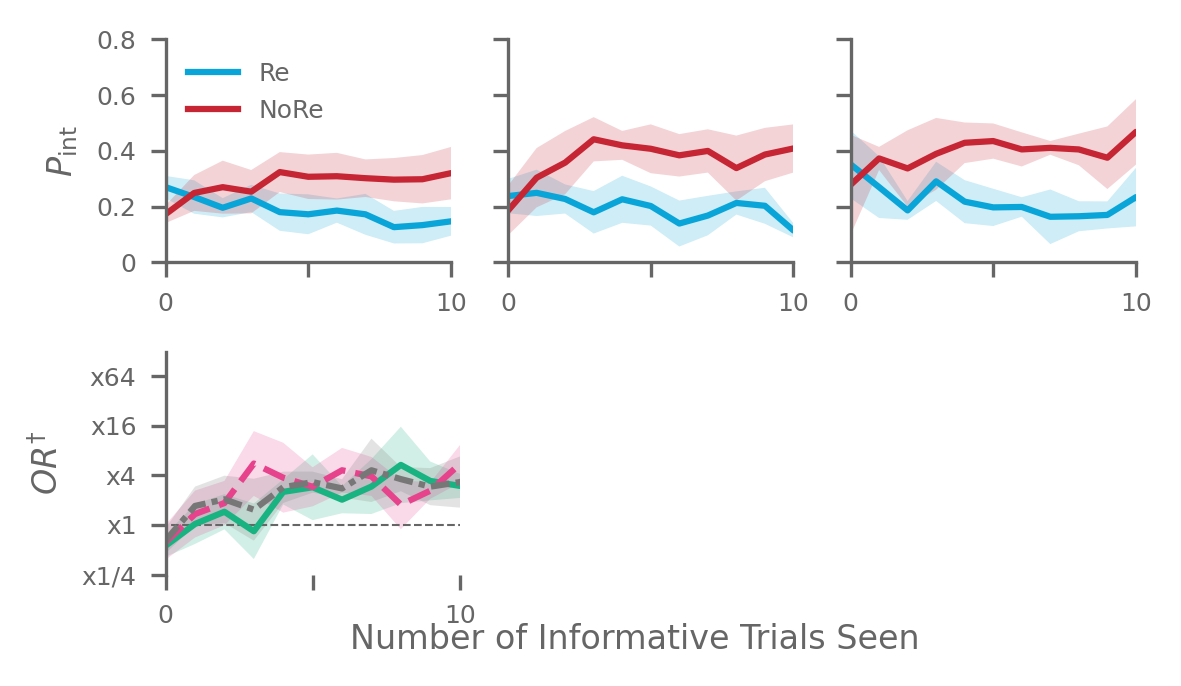

In [20]:
fig = figure_cm(COL1_5 - 1, 6, dpi=300)
hspace = 0.4
wspace = 0.2
gridspec_kw = {"hspace": hspace, "wspace": wspace}
subfigs = [None, fig]

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes, delete_axes = subfigs[1].subplots(2, 3, sharey=True, gridspec_kw=gridspec_kw)
for ax in delete_axes:
    ax.remove()

######
# 5A #
######
figure5a("NCM", ax=axes[0])
figure5a("HVC", ax=axes[1])
figure5a("CTRL", ax=axes[2])

for ax in axes:
    draw_probability_axes_markers(ax=ax)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)

axes[0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)
axes[0].legend(fontsize=6, loc="upper left", frameon=False)

# 3D: Lesioned subject odds ratios
subfigs_bottom = subfigs[1].subfigures(1, 1)
delete_axes, axes = subfigs_bottom.subplots(2, 2, gridspec_kw=dict(width_ratios=[1, 2], **gridspec_kw))
for ax in delete_axes:
    ax.remove()


######
# 5B #
######
figure5b(ax=axes[0])

draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=axes[0])
axes[0].set_ylim(-2, 7)
draw_k_axis(k_max=11, ax=axes[0])
axes[0].set_ylabel(r"$OR^{\dagger}$", fontsize=8)
border(axes[0], 1, 0, 0, 0)

axes[1].remove()

fig.supxlabel("Number of Informative Trials Seen", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("fig5.svg"), format="svg", bbox_inches="tight")


### Figure 5b Stats

We will do the same model comparisons as in Figure 4b; mixed linear models with subject as random effect and either just k or k and lesion treatment as the fixed effects. The model comparison will be made using the likelihood-ratio test.

In [21]:
def load_treatments_5b(treatments=("NCM", "HVC", "CTRL")):
    """Load the data of learning S2 after lesion for one of the three treatment groups"""
    logors = []
    for treatment in treatments:
        tsvk = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)

        for i in range(tsvk.k_max):
            logOR = tsvk.logOR_by_subjects(k=i)
            logOR["Treatment"] = treatment
            logOR["k"] = i
            logors.append(logOR)

    learning_curve_logors = pd.concat(logors)
    return learning_curve_logors

/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/

Base model (Just informative trials)


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: logOR    
No. Observations: 231     Method:             ML       
No. Groups:       21      Scale:              1.8292   
Min. group size:  11      Log-Likelihood:     -409.8039
Max. group size:  11      Converged:          No       
Mean group size:  11.0                                 
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.104     0.213  0.488  0.626  -0.313   0.521
k          0.213     0.028  7.569  0.000   0.158   0.268
Group Var  0.369     0.277                              
=======================================================

"""

Alternate model (Including Lesion Treatment)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM  Dependent Variable:  logOR    
No. Observations:   231      Method:              ML       
No. Groups:         21       Scale:               1.8998   
Min. group size:    11       Log-Likelihood:      -407.3863
Max. group size:    11       Converged:           Yes      
Mean group size:    11.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.194    0.306  0.634 0.526 -0.405  0.793
Treatment[T.HVC]  0.140    0.338  0.413 0.679 -0.523  0.803
Treatment[T.NCM] -0.287    0.319 -0.899 0.369 -0.913  0.339
k                 0.213    0.029  7.427 0.000  0.157  0.269
Group Var         0.119    0.068                           
===========================================================

"""

Likelihood ratio test result
The hypothesis that the two models are equally likely is not rejected
Chi2(2) = 4.835, p=0.08914


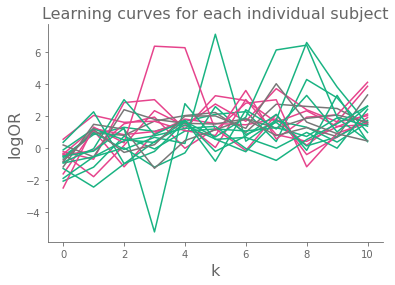

In [22]:
learning_curve_logors = load_treatments_5b(["NCM", "HVC", "CTRL"])

base_model = smf.mixedlm(
    "logOR ~ k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="1",
).fit(reml=False)

alt_model = smf.mixedlm(
    "logOR ~ Treatment + k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="1",
).fit(reml=False)

pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)

# This is so that the output is not interleaved with the non-convergence warnings
# I do this instead of suppressing the warnings, since it is important to know that the model did not converge.
time.sleep(0.1)

print("Base model (Just informative trials)")
print("====================================")
display(base_model.summary())

print("Alternate model (Including Lesion Treatment)")
print("============================================")
display(alt_model.summary())

print("Likelihood ratio test result")
print("============================")
if pvalue < 0.05:
    print("The hypothesis that the two models are equally likely is rejected")
    print("The mixed effects model with Lesion Treatment as a parameter better explains the data")
else:
    print("The hypothesis that the two models are equally likely is not rejected")

print(f"Chi2({dof}) = {x:.3f}, p={pvalue:.5f}")

for subj, subjdf in learning_curve_logors.groupby("Subject"):
    plt.plot(np.arange(11), subjdf["logOR"], color=COLORMAP[subjdf.iloc[0]["Treatment"]])
    plt.xlabel("k", fontsize=16)
    plt.ylabel("logOR", fontsize=16)
plt.title("Learning curves for each individual subject", fontsize=16)
border(plt.gca(), 1, 0, 0, 1)
plt.show()
plt.close(plt.gcf())

The base model did not converge, but the alternate model did. We can still interpret the log-likelihood of the base model (without convergence) as a lower bound on the likelihood. Thus, the p-value from the likelihood-ratio test is a lower bound. Since it is not significant, we know that our p-value is greater than 0.089, and thus we do not reject the null hypothesis that the logOR is different for different treatments. This matches the visual interpretation of the figure.

## Figure 6

Plotting the overall performance on new (S2) stimuli

In [23]:
def figure_6(call_type: str, treatment: str, ax: plt.Axes = None):
    """Plot the overall odds ratios when the stimuli are well learned
    """
    if ax is None:
        ax = plt.gca()
        
    colormap = {
        "NCM": NCM_COLOR,
        "HVC": HVC_COLOR,
        "CTRL": CTRL_COLOR
    }

    tsvk_S1_pre = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
    ])
    tsvk_S1_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
    ])
    tsvk_S2_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_6v6_d2_S2", "SovsSo_8v8_d2_S2"])
    ])
        
    scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
    scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
    scores_3 = tsvk_S2_post.fisher_exact_by_subjects(side="greater")
    
    mean_1 = np.mean(scores_1["logOR"])
    mean_2 = np.mean(scores_2["logOR"])
    mean_3 = np.mean(scores_3["logOR"])
    
    sem_1 = np.std(scores_1["logOR"]) / np.sqrt(len(scores_1))
    sem_2 = np.std(scores_2["logOR"]) / np.sqrt(len(scores_2))
    sem_3 = np.std(scores_2["logOR"]) / np.sqrt(len(scores_3))

    ax.plot([0, 1, 2], np.array([scores_1["logOR"], scores_2["logOR"], scores_3["logOR"]]), alpha=1, linewidth=1, color="0.8")

    ax.scatter(0 * np.ones(len(scores_1)), scores_1["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(1 * np.ones(len(scores_2)), scores_2["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(2 * np.ones(len(scores_3)), scores_3["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    
    dof = len(scores_1) - 1
    print(" Paired t-test results:")
    print(" S1 vs S1*")
    tstat, pvalue = scipy.stats.ttest_rel(scores_2["logOR"], scores_1["logOR"], alternative="less")
    issig = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "n.s."
    print(f" P = {pvalue:.4f} ({issig}), T({dof}) = {tstat}")
    print(" S1 vs S2*")
    tstat, pvalue = scipy.stats.ttest_rel(scores_3["logOR"], scores_1["logOR"], alternative="less")
    issig = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "n.s."
    print(f" P = {pvalue:.4f} ({issig}), T({dof}) = {tstat}")
    
    print()
    print(" Is above zero results:")
    print(" S1*")
    tstat, pvalue = scipy.stats.ttest_1samp(scores_2["logOR"], 0, alternative="greater")
    issig = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "n.s."
    print(f" P = {pvalue:.6f} ({issig}), T({dof}) = {tstat}")
    print(" S2*")
    tstat, pvalue = scipy.stats.ttest_1samp(scores_3["logOR"], 0, alternative="greater")
    issig = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "n.s."
    print(f" P = {pvalue:.6f} ({issig}), T({dof}) = {tstat}")

    print()
    ax.errorbar(
        [0.1, 1.1, 2.1], 
        [mean_1, mean_2, mean_3], 
        2 * np.array([sem_1, sem_2, sem_3]),
        linewidth=1.5, markersize=4, markerfacecolor="white", color=colormap[treatment], marker="d")
    
    

Figure Dimensions 10.60cm x 3.00cm
Song NCM
--------
 Paired t-test results:
 S1 vs S1*
 P = 0.0286 (*), T(9) = -2.178804839410887
 S1 vs S2*
 P = 0.0454 (*), T(9) = -1.8932050376446299

 Is above zero results:
 S1*
 P = 0.001284 (**), T(9) = 4.127956138987727
 S2*
 P = 0.000999 (***), T(9) = 4.297165549133576

DC NCM
--------
 Paired t-test results:
 S1 vs S1*
 P = 0.0010 (***), T(9) = -4.327177675236983
 S1 vs S2*
 P = 0.0006 (***), T(9) = -4.656499673884394

 Is above zero results:
 S1*
 P = 0.000349 (***), T(9) = 5.041670211441151
 S2*
 P = 0.004033 (**), T(9) = 3.384817307190527

SO HVC
--------
 Paired t-test results:
 S1 vs S1*
 P = 0.0427 (*), T(6) = -2.0570577869219155
 S1 vs S2*
 P = 0.7858 (n.s.), T(6) = 0.849023043077515

 Is above zero results:
 S1*
 P = 0.000022 (***), T(6) = 10.533615744977151
 S2*
 P = 0.000054 (***), T(6) = 8.953502734617253

DC HVC
--------
 Paired t-test results:
 S1 vs S1*
 P = 0.0795 (n.s.), T(6) = -1.6079216016785591
 S1 vs S2*
 P = 0.0008 (***), 

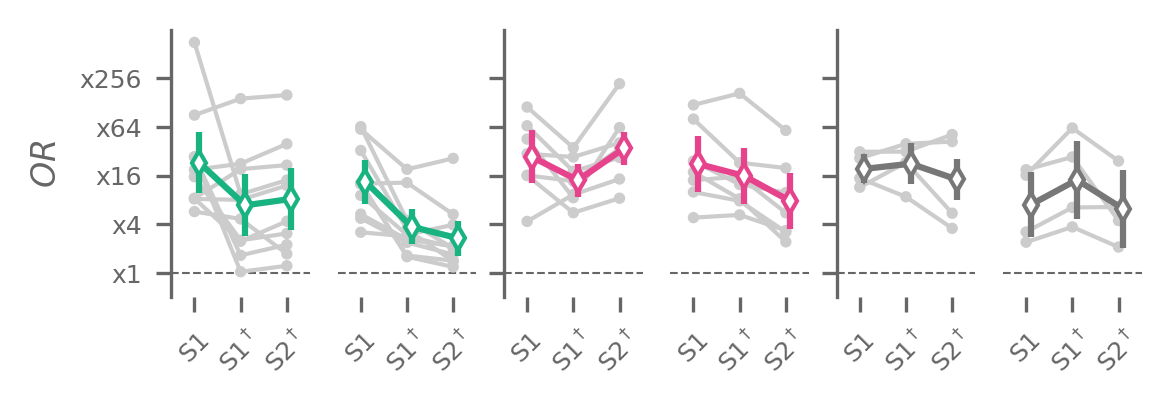

In [24]:
fig = figure_cm(COL1_5 - 1, 3, dpi=300)
axes = fig.subplots(1, 6)

print("Song NCM")
print("--------")
figure_6("SO", "NCM", ax=axes[0])

print("DC NCM")
print("--------")
figure_6("DC", "NCM", ax=axes[1])

print("SO HVC")
print("--------")
figure_6("SO", "HVC", ax=axes[2])

print("DC HVC")
print("--------")
figure_6("DC", "HVC", ax=axes[3])

print("SO CTRL")
print("--------")
figure_6("SO", "CTRL", ax=axes[4])

print("DC CTRL")
print("--------")
figure_6("DC", "CTRL", ax=axes[5])

for ax in axes:
    border(ax, 1)
    ax.set_xlim(-0.5, 2.5)

for ax in axes:
    draw_logor_axes_markers(smallest=-2, biggest=8, convert_log=False, ax=ax)
    ax.set_ylim(-1, 10)
    border(ax, 1)
    
for ax in axes[1::2]:
    border(ax)
    ax.set_yticks([])
    
for ax in axes[[2, 4]]:
    ax.tick_params(labelleft=False)

axes[0].set_ylabel("$OR$", fontsize=8)

for ax in axes:
    ax.set_xticks(
        [0, 1, 2],
        ["S1", "S1$^\dagger$", "S2$^\dagger$"],
        rotation=45,
        fontsize=6)

if SAVE_FIGS:
    fig.savefig(savedir("fig6.svg"), format="svg", bbox_inches="tight")


## Figure 7

Lesion size analysis on memory effect

The first part generates the summary figures

In [25]:
from zf_data.load_data import load_lesion_summary_table, load_subject_lesion_tables
from zf_data.stats import linreg
import pandas as pd
import statsmodels.regression
import statsmodels.api as sm


In [26]:
lesion_summary_table = load_lesion_summary_table()

In [27]:
lesion_summary_table

,Subject,L-CD (mm^3),L-CV (mm^3),L-RD (mm^3),L-RV (mm^3),R-CD (mm^3),R-CV (mm^3),R-RD (mm^3),R-RV (mm^3),TotalVolume (mm^3),HP,L,NCL,Cb,CM,HVC
0,BlaGre1349M,0.099476,0.000000,0.111854,0.000000,0.405746,0.031751,0.000000,0.000000,0.648828,1,0,1,0,0,0
1,XXXBlu0031M,0.134680,0.043486,0.182173,0.052694,0.000000,0.000000,0.099761,0.106353,0.619148,0,1,1,0,1,0
2,HpiGre0651M,0.096018,0.120710,0.140431,0.027856,0.139041,0.121493,0.206499,0.066585,0.918634,0,0,1,0,1,1
3,GreBla3404M,0.377925,0.132724,0.008446,0.000000,0.015056,0.058582,0.000000,0.000000,0.592733,1,0,0,0,0,0
4,GreBlu5039F,0.115266,0.025727,0.192688,0.000000,0.051460,0.008768,0.000000,0.000000,0.393909,2,1,0,1,1,0
5,WhiBlu5805F,0.091170,0.025224,0.202312,0.005355,0.013773,0.000000,0.296019,0.000000,0.633853,0,2,3,0,1,0
6,RedHpi0710F,0.028780,0.046094,0.101825,0.004671,0.009868,0.027441,0.092718,0.078331,0.389727,1,0,2,0,1,1
7,XXXOra0037F,0.035109,0.325156,0.000000,0.000000,0.056495,0.126573,0.017544,0.131676,0.692553,0,0,2,0,0,0
8,XXXHpi0038M,0.089552,0.003205,0.062383,0.000000,0.075883,0.000000,0.000000,0.000000,0.231024,2,0,0,1,0,0
9,GraWhi4040F,0.012917,0.013011,0.000000,0.000000,0.165030,0.127069,0.003658,0.000000,0.321686,0,0,0,0,0,0


In [28]:
def get_lesion_size(subject):
    if np.any(lesion_summary_table.Subject == subject):
        return lesion_summary_table[lesion_summary_table.Subject == subject].iloc[0]["TotalVolume (mm^3)"]
    else:
        return 0.0

In [29]:
def figure_7(call_type: str, ax: plt.Axes = None):
    """Create a scatter plot between NCM lesion size and change in logOR before and after lesion
    
    Also fit a best fit line just to the NCM points
    """
    if ax is None:
        ax = plt.gca()
        
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_S1_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        tsvk_S1_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        
        scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
        scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
        assert np.all(scores_1["Subject"] == scores_2["Subject"])
        delta = scores_2["logOR"] - scores_1["logOR"]
        
        lesion_sizes = [get_lesion_size(subject) for subject in scores_1["Subject"]]
        
        ax.scatter(
            lesion_sizes,
            delta,
            s=30,
            linewidth=1,
            facecolor="none",
            label=treatment,
            edgecolor=COLORMAP[treatment]
        )
    
        if treatment == "NCM":
            x_data = lesion_sizes
            y_data = delta

            x_data = sm.add_constant(x_data)
            result = statsmodels.regression.linear_model.OLS(y_data, x_data)
            result = result.fit()
            print("Best fit line to NCM data")
            print("-------------------------")
            print(result.summary())
            
            x = np.linspace(-0.1, 1.1, num=3)
            ax.plot(x, result.params[0] + result.params[1] * x, linewidth=1, color=NCM_COLOR, linestyle="--", zorder=-1)

            pvalue = result.pvalues[1]
            r2_adj = result.rsquared_adj
            ax.text(
                0.04,
                0.02, 
                "$R^2_{adj}$" + f"={r2_adj:.2f}\n" + "$p=$" + f"{pvalue:.2f}",
                fontsize=8, 
                verticalalignment="bottom",
                horizontalalignment="left",
                color=NCM_COLOR,
                transform=ax.transAxes
            )

#### Compare the slopes of the lines



Figure Dimensions 10.60cm x 5.00cm
Best fit line to NCM data
-------------------------
                            OLS Regression Results                            
Dep. Variable:                  logOR   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.7021
Date:                Thu, 10 Mar 2022   Prob (F-statistic):              0.426
Time:                        12:12:30   Log-Likelihood:                -22.619
No. Observations:                  10   AIC:                             49.24
Df Residuals:                       8   BIC:                             49.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Best fit line to NCM data
-------------------------
                            OLS Regression Results                            
Dep. Variable:                  logOR   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2.719
Date:                Thu, 10 Mar 2022   Prob (F-statistic):              0.138
Time:                        12:12:30   Log-Likelihood:                -15.213
No. Observations:                  10   AIC:                             34.43
Df Residuals:                       8   BIC:                             35.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


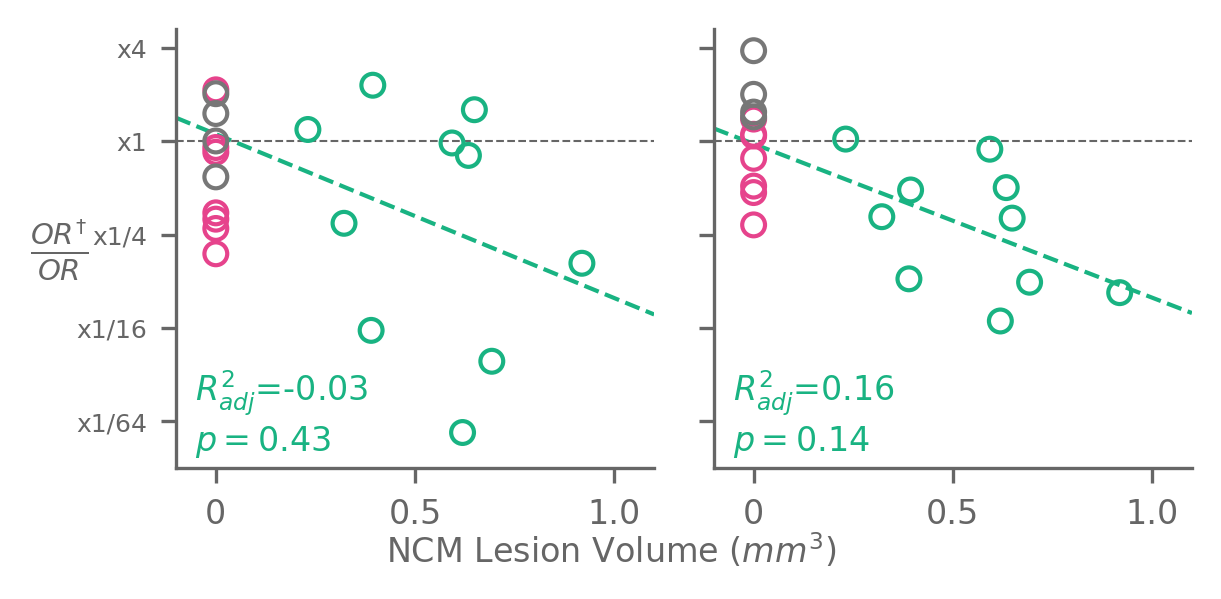

In [30]:
fig = figure_cm(COL1_5 - 1, 5, dpi=300)

axes = fig.subplots(1, 2, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_7("SO", ax=axes[0])
figure_7("DC", ax=axes[1])

axes[0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes:
    ax.set_xlim(-0.1, 1.1)
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    ax.set_xticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)

fig.tight_layout()
fig.supxlabel("NCM Lesion Volume ($mm^3$)", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("fig7.svg"), format="svg", bbox_inches="tight")
